In [54]:
# Elementos de matriz y funciones personalizadas
from elementos_matriz import *
import matplotlib.pyplot as plt

# Energía de la molécula de hidrógeno $\mathrm{H}_2$
---

## Elementos de matriz

Dado que el cálculo de las energías $E_1^\text{RHF}$, $E_2^\text{RHF}$ y $E_1^\text{UHF}$ dependen de los mismos elementos de matriz, se calcularán todos los elementos de matriz para un rango de distancias interatómicas y posteriormente estos serán consultados para la determinación de la energía.

In [55]:
# Energía del átomo de hidrógeno en la base STO-3G
RB = np.array([1000000, 0, 0])
EH_STO3G = fpp(1, d, a, RA, RB, ZA, ZB)

In [56]:
# cargar elementos de matriz previamente calculados
distancias, h11, h22, J11, J22, J12, K12, hnuc = elementos_H2('cargar')

# calcular elementos de matriz en un intervalo
# intervalo = [0.15, 7.06, 0.05]
# distancias, h11, h22, J11, J22, J12, K12, hnuc = elementos_H2('calcular', intervalo)

Elementos de matriz y distancias interatómicas cargadas.


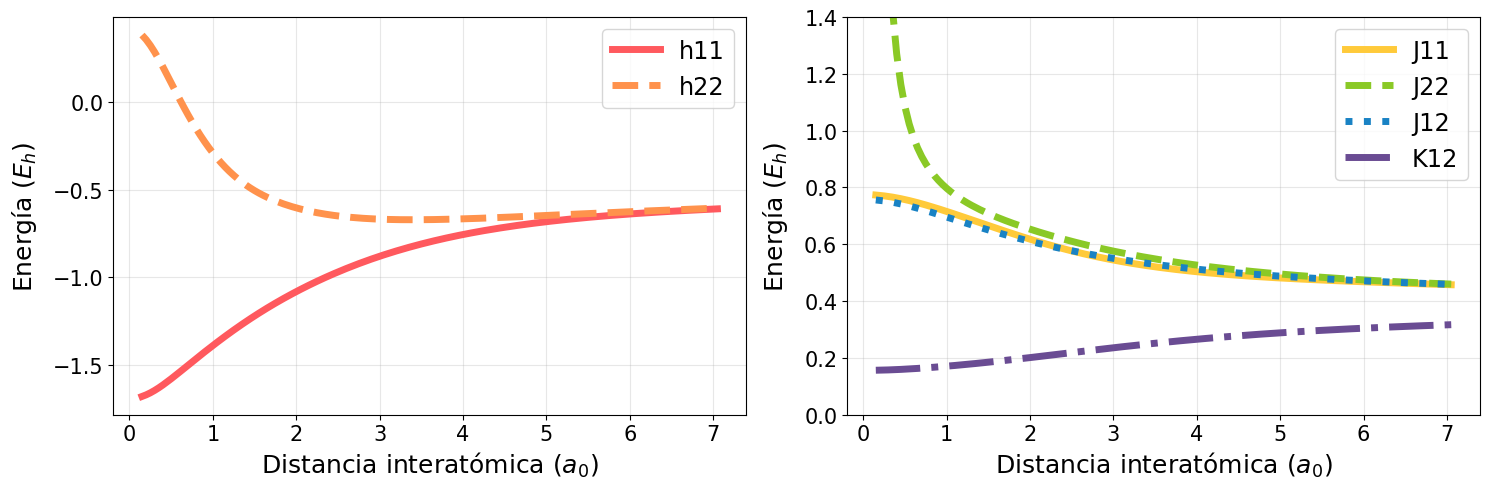

In [68]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # 1 fila, 1 columnas, tamaño de figura (15, 5)
linewidth, fontsize = 5, 18

###################
### Gráfica derecha
###################
axs[0].plot(distancias, h11, linewidth=linewidth, linestyle='solid', label='h11', color='#ff595e')
axs[0].plot(distancias, h22, linewidth=linewidth, linestyle='dashed', label='h22', color='#ff924c')
axs[0].legend(fontsize='xx-large')
axs[0].set_xlabel(r'Distancia interatómica ($a_0$)', fontsize=fontsize)
axs[0].set_ylabel(r'Energía ($E_h$)', fontsize=fontsize, labelpad=10)
axs[0].tick_params(axis='both', which='major', labelsize=15)
axs[0].grid(alpha=0.3)

#####################
### Gráfica izquierda
#####################
axs[1].plot(distancias, J11, linewidth=linewidth, linestyle='solid', label='J11', color='#ffca3a')
axs[1].plot(distancias, J22, linewidth=linewidth, linestyle='dashed', label='J22', color='#8ac926')
axs[1].plot(distancias, J12, linewidth=linewidth, linestyle='dotted', label='J12', color='#1982c4')
axs[1].plot(distancias, K12, linewidth=linewidth, linestyle='dashdot', label='K12', color='#6a4c93')
axs[1].set_xlabel(r'Distancia interatómica ($a_0$)', fontsize=fontsize)
axs[1].set_ylabel(r'Energía ($E_h$)', fontsize=fontsize, labelpad=10)
axs[1].legend(fontsize='xx-large')
axs[1].tick_params(axis='both', which='major', labelsize=15)
axs[1].set_ylim(0,1.4)
axs[1].grid(alpha=0.3)

fig.tight_layout()
plt.show()

fig.savefig('imgs/elementos_matriz.png')

## Hartree-Fock Restringido (RHF)

La función de onda RHF para el estado base y el doblemente excitado son

$$\Psi_1^\text{RHF} = \ket{\chi_1 \bar{\chi}_1} \,,$$
$$\Psi_2^\text{RHF} = \ket{\chi_2 \bar{\chi}_2}\,.$$

Cuyas energías asociadas son

$$E_1^\text{RHF} = 2h_{11} + J_{11} + h_\text{nuc} \,,$$

$$E_2^\text{RHF} = 2h_{22} + J_{22} + h_\text{nuc} \,.$$

In [58]:
RHF1 = 2*h11 + J11 + hnuc # energía restringida (orbital ligante)
RHF2 = 2*h22 + J22 + hnuc # energía restringida (orbital antiligante)

# guardar valores para la energía
# (descomentar en caso de generar nuevos elementos de matriz)
# guardar('RHF1', RHF1)
# guardar('RHF2', RHF2)

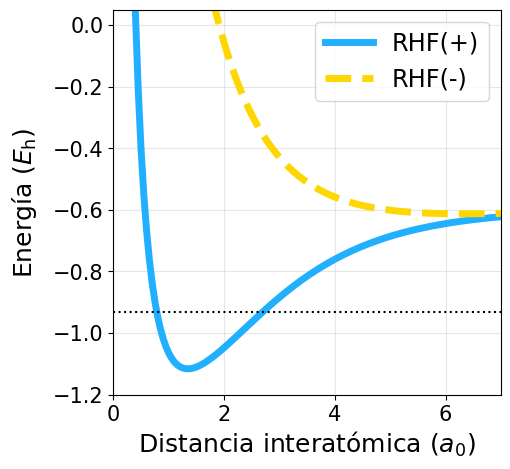

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))  # 1 fila, 1 columnas, tamaño de figura (15, 5)
linewidth, fontsize = 5, 18

ax.plot(distancias, RHF1, label='RHF(+)', linestyle='solid', linewidth=linewidth, color='#21b0fe') # energías RHF orbital ligante
ax.plot(distancias[3:], RHF2[3:], label='RHF(-)', linestyle='dashed', linewidth=linewidth, color='#fed700') # energías RHF orbital antiligante
ax.axhline(y = 2*EH_STO3G, color='black', linestyle='dotted') # energía base 2 átomos de hidrógeno (STO-3G)

ax.set_xlabel(r'Distancia interatómica ($a_0$)', fontsize=fontsize)
ax.set_ylabel(r'Energía ($E_\mathrm{h}$)', fontsize=fontsize, labelpad=10)

ax.set_xlim(0, 7)
ax.set_ylim(-1.2, 0.05)
ax.legend(fontsize='xx-large')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.grid(alpha=0.3)

plt.show()
fig.savefig('imgs/RHF.png')

---
## Hartree-Fock sin restricción (UHF)

$$\eta_1 = \cos2\theta_1 =  \frac{E_2^\text{RHF} - E_1^\text{RHF}}{J_{11} + J_{22} - 2J_{12} + 4K_{12}}$$

$$\eta_2 = \cos2\theta_2 =  \frac{E_1^\text{RHF} - E_2^\text{RHF}}{J_{11} + J_{22} - 2J_{12} + 4K_{12}} = -\eta_1$$

In [60]:
def E_UHF(orbital:str, i:int):
    """ Cálculo de la energía no restringida (UHF)
    
    Parámetros:
        orbital: 'ligante' o 'antiligante' (en t=0)
        i: índice de la lista
    """

    eta1 = (RHF2[i] - RHF1[i]) / (J11[i] + J22[i] - 2*J12[i] + 4*K12[i]) # eta del caso ligante
    if orbital == 'ligante': # caso ligante
        eta = eta1
        theta = 0 if (eta > 1) or (eta < 0) else np.arccos(eta)/2
    else: # caso antiligante
        eta = -eta1
        theta = 0 if (eta > 1) or (eta < 0) else np.arccos(eta)/2
    
    cos = np.cos(theta)
    sin = np.sin(theta)

    if orbital == 'ligante':
        E1 = 2*h11[i]*np.power(cos,2) + 2*h22[i]*np.power(sin,2)
        E2 = J11[i]*np.power(cos,4) + J22[i]*np.power(sin,4) 
    else:
        E1 = 2*h11[i]*np.power(sin,2) + 2*h22[i]*np.power(cos,2)
        E2 = J11[i]*np.power(sin,4) + J22[i]*np.power(cos,4)

    E3 = (2*J12[i]-4*K12[i])*np.power(cos,2)*np.power(sin,2)
    Etot = E1 + E2 + E3 + hnuc[i] # energía total
    
    return  Etot, theta, eta

In [61]:
ang1, eta1 = [], [] # lista de ángulos para cada distancia internuclear
ang2, eta2 = [], [] # lista de ángulos para cada distancia internuclear

UHF1 = [] # energías UHF, orbital ligante en t=0
UHF2 = [] # energías UHF, orbital antiligante en t=0
for i in range(len(distancias)):
    # caso orbital lignante en t=0
    energia1, theta1, eta = E_UHF('ligante', i)
    UHF1.append(energia1)
    ang1.append(theta1)
    eta1.append(eta)
    # caso orbital antiligante en t=0
    energia2, theta2, eta = E_UHF('antiligante', i)
    UHF2.append(energia2)
    ang2.append(theta2)
    eta2.append(eta)

guardar('UHF1', UHF1)
guardar('UHF2', UHF2)

In [62]:
# índice del primer ángulo diferente de cero/NaN, RHF
index = next((i for i, x in enumerate(ang1) if x), None)
x0, y0 = distancias[index], UHF1[index]
x_ang, y_ang = distancias[index], ang1[index]

# índice del primer ángulo diferente de cero/NaN, UHF
index2 = next((i for i, x in enumerate(ang1) if x), np.nan)
xUHF, yUHF = distancias[index2], UHF1[index2]
xUHG_ang, yUHG = distancias[index2], ang1[index2]

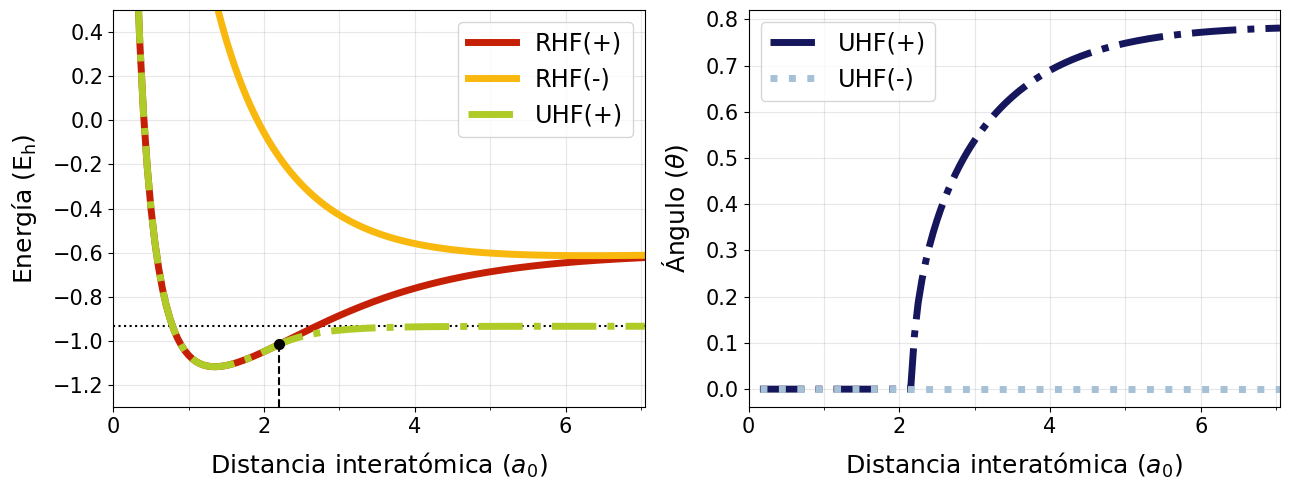

In [63]:
fig, axs = plt.subplots(1, 2, figsize=(13, 5))  # 1 fila, 1 columnas, tamaño de figura (15, 5)
linewidth, fontsize = 5, 18

###################
### Gráfica derecha
###################
axs[0].axhline(y = 2*EH_STO3G, color='black', linestyle='dotted') # energía base 2 átomos de hidrógeno (STO-3G)

axs[0].plot(distancias, RHF1, label='RHF(+)', linestyle='solid', linewidth=linewidth, color='#c51f05') # energías RHF orbital ligante
axs[0].plot(distancias[3:], RHF2[3:], label='RHF(-)', linestyle='solid', linewidth=linewidth, color='#f9b80d') # energías RHF orbital antiligante
axs[0].plot(distancias, UHF1, label='UHF(+)', linestyle='dashdot', linewidth=linewidth, color='#aecb28') # energías UHF(+)
# axs[0].plot(distancias, UHF2, label='UHF(-)', linestyle='dotted', linewidth=width, color='#006d66') # energías UHF(-)

ymin, ymax = -1.3, 0.5
axs[0].vlines(x=x0, ymin=ymin, ymax=y0, color='black', linestyle='dashed')
axs[0].plot(x0, y0, ls="", marker="o", color='black', markersize=7) # punto a partir de donde RHF y UHF ya no son iguales

xmin, xmax = 0, 7.05
axs[0].set_xlim(xmin, xmax)
axs[0].set_ylim(ymin, ymax)
axs[0].legend(fontsize='xx-large')
axs[0].set_xlabel('Distancia interatómica ($a_0$)', fontsize=fontsize, labelpad=10)
axs[0].set_xticks(np.arange(xmin, xmax, 2))
axs[0].set_xticks(np.arange(xmin, xmax, 1), minor=True)
axs[0].set_ylabel(r'Energía ($\text{E}_\text{h}$)', fontsize=fontsize, labelpad=10)
axs[0].tick_params(axis='both', which='major', labelsize=15)
axs[0].grid(alpha=0.3, which='both')

#####################
### Gráfica izquierda
#####################
axs[1].plot(distancias, ang1, label='UHF(+)', linestyle='dashdot', linewidth=linewidth, color='#16165d') # energías UHF
axs[1].plot(distancias, ang2, label='UHF(-)', linestyle='dotted', linewidth=linewidth, color='#a6c0d5') # energías UHF

xmin, xmax = 0, 7.05
axs[1].set_xlim(xmin, xmax)
axs[1].legend(fontsize='xx-large')
axs[1].set_xlabel('Distancia interatómica ($a_0$)', fontsize=fontsize, labelpad=10)
axs[1].set_xticks(np.arange(xmin, xmax, 2))
axs[1].set_xticks(np.arange(xmin, xmax, 1), minor=True)
axs[1].set_ylabel(r'Ángulo ($\theta$)', fontsize=fontsize, labelpad=10)
axs[1].tick_params(axis='both', which='major', labelsize=15)
axs[1].grid(alpha=0.3, which='both')

fig.tight_layout()
plt.show()

fig.savefig('imgs/RHFvsUHF.png')

---
## Interacción de configuraciones CI

La función de onda CI es

$$\ket{\Phi_0} = c_0 \ket{\Psi_0} + c_{12}^{34} \ket{\Psi_{12}^{34}} \,.$$

donde
$$\ket{\Psi_0} = \ket{\chi_1 \chi_2} \qquad \text{y} \qquad \ket{\Psi_{12}^{34}} = \ket{\chi_3 \chi_4} \,.$$

La matriz de configuración de interacción es

$$
\mathbf{H} =
\begin{pmatrix}
    \langle \Psi_0 | \mathcal{H}_\mathrm{el} | \Psi_0 \rangle
        & \langle \Psi_0 | \mathcal{H}_\mathrm{el} | \Psi_{12}^{34} \rangle \\
    \langle \Psi_{12}^{34} | \mathcal{H}_\mathrm{el} | \Psi_0 \rangle
        & \langle \Psi_{12}^{34} | \mathcal{H}_\mathrm{el} | \Psi_{12}^{34} \rangle \\
\end{pmatrix} =
\begin{pmatrix}
    2h_{11} + J_{11} & K_{12} \\
    K_{12} & 2h_{22} + J_{22} \\
\end{pmatrix}
+ \mathbb{1} h_\mathrm{nuc}
$$

Los eigenvalores resultantes de diagonalizar la matriz $\mathbf{H}$ es
$$ E_{\pm} = \frac{H_{11} + H_{22} \pm \sqrt{(H_{11} - H_{22})^2 + 4|H_{12}|^2}}{2}
= \frac{1}{2} (H_{11} + H_{22} \pm \sqrt{\Delta}) \,.$$

In [64]:
# elementos de la matriz de configuración
H11 = RHF1
H22 = RHF2
H12 = K12

# energías asociadas a la diagonalización
delta = np.square(H11-H22) + 4*np.square(H12) # discriminante
E1 = (H11 + H22 - np.sqrt(delta))/ 2 # E- (caso base)
E2 = (H11 + H22 + np.sqrt(delta))/ 2 # E+ (caso excitado)

El eigenvector $\mathbf{c}_\pm$ asociado a la energía $E_\pm$ es $\mathbf{c} = (c_0^\pm, c_1^\pm)^T$ donde

$$ c_0^\pm \equiv \frac{H_{12}}{\sqrt{| E_{\pm} - H_{11}|^2 + |H_{12}|^2}} \,,$$

$$ c_1^\pm \equiv \frac{E_{\pm} - H_{11}}{\sqrt{|E_{\pm} - H_{11}|^2 + |H_{12}|^2}} \,.$$

In [65]:
# Cálculo de coeficientes c1 y c2

# coefs. asociados a E-
denM = np.sqrt(np.square(E1 - H11) + np.square(H12))
c0 = H12 / denM
c1 = (E1 - H11) / denM

CI = np.square(c0)*RHF1 + np.square(c1)*RHF2 + 2*c0*c1*H12

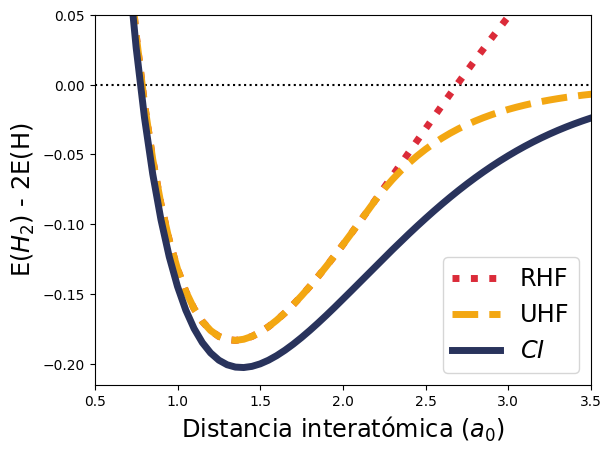

In [67]:
plt.axhline(0, color='black', linestyle='dotted') # energía base 2 átomos de hidrógeno (STO-3G)
width = 5

plt.plot(distancias, RHF1-2*EH_STO3G, linewidth=width, linestyle='dotted', label='RHF', color='#db2b39')
plt.plot(distancias, UHF1-2*EH_STO3G, linewidth=width, linestyle='dashed', label='UHF', color='#f3a712')
plt.plot(distancias, CI-2*EH_STO3G, linewidth=width, linestyle='solid', label='$CI$', color='#29335c')

xmin, xmax = 0.5, 3.5
plt.xlim(xmin, xmax)
ymin, ymax = -0.215, 0.05
plt.ylim(ymin, ymax)

plt.xlabel('Distancia interatómica ($a_0$)', fontsize='xx-large')
plt.ylabel(r'E($H_2$) - 2E(H)', fontsize='xx-large')

plt.legend(fontsize='xx-large')
plt.savefig('imgs/CI.png')
plt.show()

---
## Punto de control

Aquí se calculan todas las energías en cuestión para una distancia interatómica de $R = 1.4a_0$

In [28]:
RB = np.array([1.4, 0, 0])
hnuc = 1/(np.linalg.norm(RA-RB))
h11, h22, J11, J22, J12, K12 = elementos_matriz(d, a, RA, RB, ZA, ZB)

In [29]:
RHF1 = 2*h11 + J11 + hnuc
RHF2 = 2*h22 + J22 + hnuc
print("--- Energías restringidas ---")
print("RHF (ligante):", RHF1)
print("RHF (antiligante):", RHF2)

Energías restringidas
RHF (ligante): -1.1157287495398318
RHF (antiligante): 0.48439549607543997


In [33]:
eta = (RHF2 - RHF1) / (J11_val + J22 - 2*J12 + 4*K12) # eta del caso ligante
theta = 0 if (eta > 1) or (eta < 0) else np.arccos(eta)/2
cos = np.cos(theta)
sin = np.sin(theta)

E1 = 2*h11_val*np.power(cos,2) + 2*h22_val*np.power(sin,2)
E2 = J11*np.power(cos,4) + J22*np.power(sin,4)
E3 = (2*J12-4*K12)*np.power(cos,2)*np.power(sin,2)
UHF = E1 + E2 + E3 + hnuc # energía total

print("--- Energía no restringida ---")
print("UHF (ligante):", UHF)

--- Energía no restringida ---
UHF (ligante): -1.1157287495398318


In [34]:
# elementos de la matriz de configuración
H11 = RHF1
H22 = RHF2
H12 = K12

# energías asociadas a la diagonalización
delta = np.square(H11-H22) + 4*np.square(H12) # discriminante
E1 = (H11 + H22 - np.sqrt(delta))/ 2 # E- (caso base)
E2 = (H11 + H22 + np.sqrt(delta))/ 2 # E+ (caso excitado)

# Cálculo de coeficientes c1 y c2

# coefs. asociados a E-
denM = np.sqrt(np.square(E1 - H11) + np.square(H12))
c0 = H12 / denM
c1 = (E1 - H11) / denM

CI = np.square(c0)*RHF1 + np.square(c1)*RHF2 + 2*c0*c1*H12

print("--- Energía CI ---")
print("CI (estado base):", CI)

--- Energía CI ---
CI (estado base): -1.1360042137264037
